In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import diags
plt.rcParams.update({'font.size': 14})

def plotresult(x,I,v,cin,Darray,Nt,title):
    colorwave = cm.plasma(np.linspace(0, 1, Nt))
    #fig = plt.figure(figsize = (15,5) )
    fig, ax = plt.subplots(figsize=(15,5))
    host = plt.subplot(1,2,1)
    par1 = host.twinx()
    par2 = host.twinx()
    color1 = 'orange'
    color2 = 'blue'
    color3 = 'green'
    host.set_xlabel('x [µm]')
    host.set_ylabel('Intensity', color=color1)
    par1.set_ylabel(r'Velocity [$\mu m/s$]', color=color2)
    par2.set_ylabel(r'Effective Diffusion coefficent [$\mu m^2/s$]', color=color3)
    host.tick_params('y', colors=color1)
    par1.tick_params('y', colors=color2)
    par2.tick_params('y', colors=color3)
    p1 = host.plot(x,I,color=color1)
    p2 = par1.plot(x,v,color=color2)
    p3 = par2.plot(x,Darray,color=color3)
    plt.title('Initial conditions')
    factor = 1.1
    host.set_ylim([0,factor*1])
    par1.set_ylim([0,factor*vactive])
    par2.set_ylim([0,factor*max(Darray)])
    par2.spines['right'].set_position(('outward', 60)) # right, left, top, bottom
    
    ax2 = plt.subplot(1,2,2)
    for i in range(1,Nt):
        if i % int(Nt/20) == 0:
            plt.plot(x,cin[:,i],c=colorwave[i])
            plt.xlabel('space ')
            plt.ylabel('concentration c')
            plt.title(str(title))
    #data = np.linspace(0, dt*Nx, Nx).reshape(Nx, 1)
    #im = ax.imshow(data, cmap='plasma')
    #divider = make_axes_locatable(ax2)
    #cax = fig.add_axes([0.75, 0.2, 0.04, 0.2])
    #plt.colorbar(im, cax=cax)
    plt.title('Time evolution')
    plt.ylim([0,1.1*np.amax(cin[:,1:])])
    
    plt.tight_layout()  
    plt.savefig(str(title)+'.svg', format='svg')
    plt.show()
    
def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = sigma**2
    distances = np.linspace(-rrange,rrange,Nx)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

In [2]:
amplitude = 1
vmin = 0                                     #Min velocity
vmax = 1                                        #Max velocity
pxtomum=0.0533#e-6                               #px to µm [µm/px]
sigma = 70*pxtomum                                     #Sigma for the Gaussian intensity profile [px]
D_0 = 1#3.85e-14*1e12                                  #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200
vdiff = vmax - vmin
vactive = 6

taur = 1
Nx = 100                     #x steps
Nt = 10000                    #t steps
L = 2*boundaryradius                       #Length of the domain ([0,L])
T = 10                        #Stop time of the simulation
#Remark T should be smaller Nt/200 to get resonable 
#results for the explicit method
start = int(Nx/2)

x = np.linspace(-boundaryradius, boundaryradius, Nx)    #x space   
t = np.linspace(0, T, Nt)    #t space
dt = t[1]-t[0]               #t step
dx = x[1] - x[0]             #x step
F = D_0 * dt/dx**2

# Dirichlet boundary conditions

For solving the ODE we need to include the boundary conditions: $u_{0}^{n} = 0$ and $u_{N_{x}}^{n} = 0$. Those initial conditions are introduced by setting $M_{0,0}=M_{N_{x},N_{x}}=1$ and $M_{0,1}=M_{N_{x},N_{x-1}}=0$. The vector b equals $b_{i}=u_{i}^{n-1}$ but with the initial conditions $b_{0}=b_{N_{x}}=0$. 

The final matrix to solve is for example in the case $ 6 \times 6$ than:

####  $
\begin{bmatrix}
 1 & 0  & 0 & 0 & 0 & 0\\
 -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right )  & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0 & 0\\
 0 & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0\\
 0 & 0  & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0\\
 0 & 0  & 0  &  -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right )\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}
\begin{bmatrix}
0\\
u_{1}^{n}\\
u_{2}^{n}\\
u_{3}^{n}\\
u_{4}^{n}\\
0
\end{bmatrix}=
\begin{bmatrix}
0\\
u_{1}^{n-1}\\
u_{2}^{n-1}\\
u_{3}^{n-1}\\
u_{4}^{n-1}\\
0
\end{bmatrix}
$

The matrix $M$ contains quantities that do not change in time. Therefore $M$ can be formed once and for all. The right hand side $b$ must be updated at each time step.

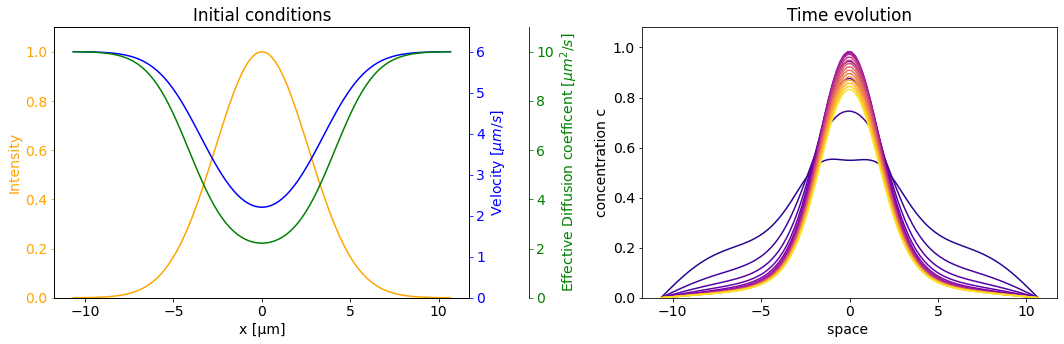

In [3]:
#Initialize velocity and diffusion coefficient profile
dist, v, I = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
Darray = np.zeros(Nx)
Darray = D_0 + v**2*taur/4
G = dt/dx**2

#Create matrix to solve the ODE
M = np.zeros((Nx,Nx))
for i in range(1,Nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1] 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1   #Dirichlet boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = 0

#Solve the ODE for every time step
c = np.zeros((Nx,Nt))
c[:,0] = np.ones(Nx)*(1/v[-1])/(max(1/v[start:]))  #initial condition: constant function with area 1
for i in range(1,Nt):
    b = c[:,i-1]                     #distribution from t-1
    b[0] = b[-1] = 0            #Set boundary values
    csingle = np.linalg.solve(M,b)   #Solve ODE
    c[:,i] = csingle#/sum(abs(csingle)*dx)   #Normalize
    
plotresult(x,I,v,c,Darray,Nt,'Explicit Solution with D(x)')

# Neumann boundary conditions
https://math.stackexchange.com/questions/2706701/neumann-boundary-conditions-in-finite-difference

Here the condition is, that the derivative at the boundary equals a certain value

### $\frac{\mathrm{d}  u_{0}^{n}}{\mathrm{d} x} = A;\; \;  \; \; \; \; \frac{\mathrm{d}  u_{N_{x}}^{n}}{\mathrm{d} x} = B$

or in our case:

### $\frac{u_{1}^{n}-u_{0}^{n}}{\Delta x}=A; \; \; \; \; \; \; \frac{u_{N_{x}}^{n}-u_{N_{x}-1}^{n}}{\Delta x}=B.$

Which is equivalent to:

### $u_{0}^{n}-u_{1}^{n}=-A\Delta x; \; \; \; \; \; \; u_{N_{x}}^{n}-u_{N_{x}-1}^{n}=B\Delta x$

The final matrix to solve is for example in the case $ 6 \times 6$ than:

####  $
\begin{bmatrix}
 1 & 0  & 0 & 0 & 0 & 0\\
 -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right )  & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0 & 0\\
 0 & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0 & 0\\
 0 & 0  & -G\alpha_{i}  & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right ) & 0\\
 0 & 0  & 0  &  -G\alpha_{i} & 1+G\left ( 3\alpha _{i}-\alpha _{i-1} \right ) & G \left ( \alpha _{i-1}-2\alpha _{i} \right )\\
 0 & 0  & 0  &  0 &  0 & 1\\
\end{bmatrix}
\begin{bmatrix}
0\\
u_{1}^{n}\\
u_{2}^{n}\\
u_{3}^{n}\\
u_{4}^{n}\\
0
\end{bmatrix}=
\begin{bmatrix}
-A \Delta x\\
u_{1}^{n-1}\\
u_{2}^{n-1}\\
u_{3}^{n-1}\\
u_{4}^{n-1}\\
B \Delta x
\end{bmatrix}
$

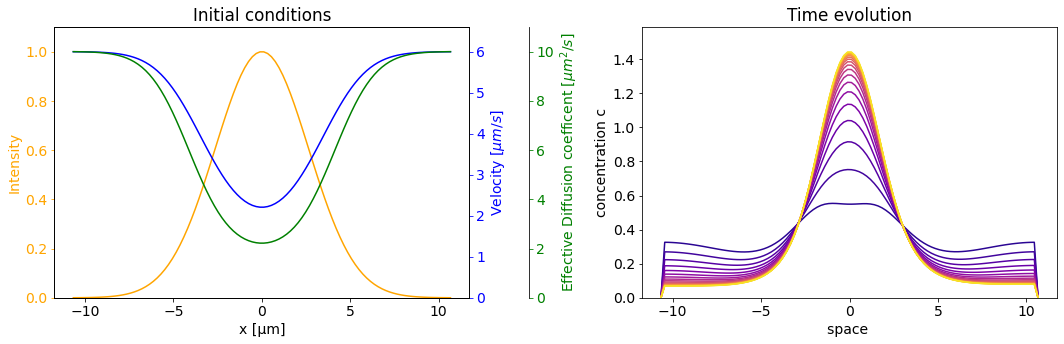

In [7]:
#Initialize velocity and diffusion coefficient profile
dist, v, I = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
Darray = np.zeros(Nx)
Darray = D_0 + v**2*taur/4
G = dt/dx**2

#Create matrix to solve the ODE
M = np.zeros((Nx,Nx))
for i in range(1,Nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1] 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1

#Solve the ODE for every time step
c = np.zeros((Nx,Nt))
c[:,0] = np.ones(Nx)*(1/v[-1])/(max(1/v[start:]))  #initial condition: constant function with area 1
for i in range(1,Nt):
    b = c[:,i-1]                     #distribution from t-1
    b[0] = b[-1] = 0            #Set boundary values
    csingle = np.linalg.solve(M,b)   #Solve ODE
    c[:,i] = csingle#/sum(abs(csingle)*dx)   #Normalize
    
#plotresult(x[1:-1],I[1:-1],v[1:-1],c[1:-1,:],Darray[1:-1],Nt,'Explicit Solution with D(x)')
plotresult(x,I,v,c,Darray,Nt,'Explicit Solution with D(x)')

## Compare ODE with Schnitzer 

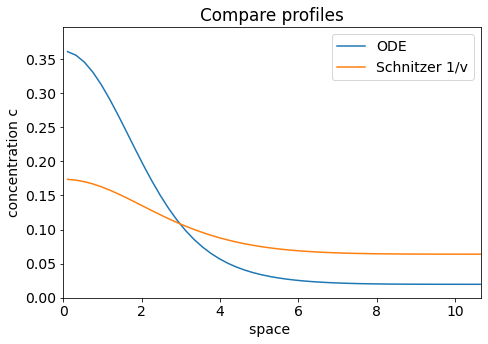

Check area under the curves
ODE: 1.0
Schnitzer: 1.0


In [13]:
fin = c[start:,-1]#+1/(Nx*dx/2)*np.ones(int(Nx/2))
fin /= sum(fin)*dx   #normalized to 1

fig= plt.figure(figsize=(7,5))
plt.plot(x[start:],fin,label='ODE')
#plt.plot(x[start:],1/(Nx*dx/2)*np.ones(int(Nx/2)))
schnitzer = 1/v[start:]
schnitzer /= sum(schnitzer)*dx
plt.plot(x[start:],schnitzer,label='Schnitzer 1/v')
plt.ylim([0,1.1*max(fin[0],schnitzer[0])])
plt.xlim([0,boundaryradius])
plt.xlabel('space ')
plt.ylabel('concentration c')
plt.legend()
plt.title('Compare profiles')
plt.tight_layout()  
plt.savefig('Compare profiles.svg', format='svg')
plt.show()

print('Check area under the curves')
print('ODE:',round(sum(fin)*dx,2))
print('Schnitzer:',round(sum(schnitzer)*dx,2))

## ------------------------------
## Everything below is non-sense

## Test to solve it without t-dependency

### $$

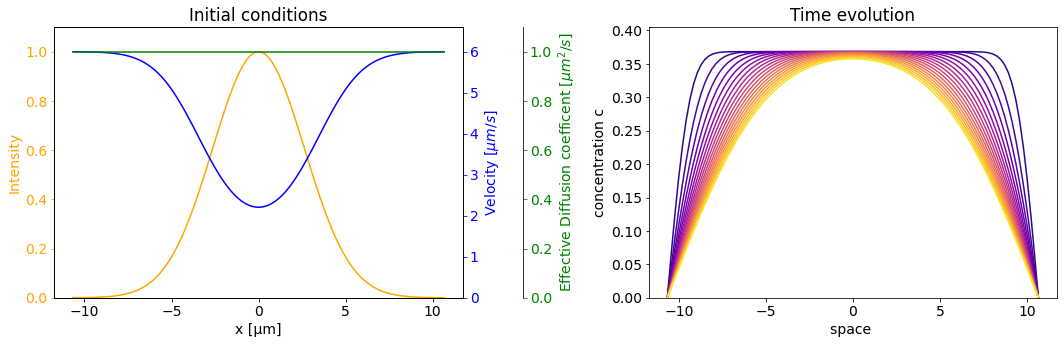

In [10]:
c = np.zeros((Nx,Nt))        #array to save the density distributions
c[:,0] = np.ones(Nx)*(1/v[-1])/(max(1/v[start:]))

for n in range(Nt-1):
    for i in range(1,Nx-1):
        c[i,n+1] = c[i,n] + F*(c[i+1,n]-2*c[i,n]+c[i-1,n])
    c[0,n+1] =  0#c[1,n+1]
    c[-1,n+1] =  0#c[-2,n+1]
    
Darray = D_0*np.ones(Nx)
plotresult(x,I,v,c,Darray,Nt,'Explicit Solution with D(x)')

In [ ]:
def initf(x,Nx):
    mini = 1
    maxi = 2
    ini = np.zeros(Nx)
    for i in range(int(Nx/2)): 
        ini[i] = (mini-maxi)/int(Nx/2)*i+maxi
        ini[i+int(Nx/2)] = -(mini-maxi)/int(Nx/2)*i+mini
    return ini#

binitial = initf(x,Nx)              #initial distribution 